# Toy experiments
  
    
    
In this notebook, we perform initial experiments to demonstrate the 'Curse of Chaos' occuring in a simple function

$f(x) = 0.1 \sin{\frac{x \omega}{\pi}} + (\frac{x}{10})^2 + 0.1$

From this function, we want to compute the gradient of its expectation, w.r.t samples taken from a normal distribution $x \sim \mathcal{N}(\mu, \sigma)$

$\nabla_{\theta} \mathbb{E}_{x \sim p(x; \theta)} [f(x)]$

To do this, use two different gradient estimation techniques:<br>
- Reparametrized gradients, which we show have high variance
- Likelihood ratio gradients, which have lower variance in chaotic environments

In [1]:
import jax.numpy as jnp
import jax.scipy
from jax import grad, vjp
from jax.test_util import check_grads
import jax.random as jrandom
import numpy as np

import matplotlib.pyplot as plt

## Constants & Utils

In [2]:
N = 1000 # Number of samples per point
num_inputs = 1000 # Number of input points in range

range_start = -10
range_end = 10

variance = 0.3 # Sampling distribution variance

# JAX utils
rand_key = jrandom.PRNGKey(1)

In [3]:
def foo(inputs, w):
    return 0.1 * jnp.sin(inputs * w / jnp .pi) + (inputs/10)**2 + 0.1

In [4]:
# TODO delete if unused
def get_func_inputs(start, end, num_points):
    return jnp.linspace(start, end, num_points)

## Monte-Carlo estimate of the function

In [5]:
def mc_function(sample_var: int, xs, w: int):
    means = jnp.array(xs, dtype=jnp.float32)
    cov = jnp.eye(num_inputs, N, dtype=jnp.float32) * sample_var

    mc_samples = jrandom.multivariate_normal(
                        key=rand_key,
                        mean=means,
                        cov=cov,
                        shape=(N,)
    )

    return foo(mc_samples, w).mean(axis=0, keepdims=False)

## Visualizing the function

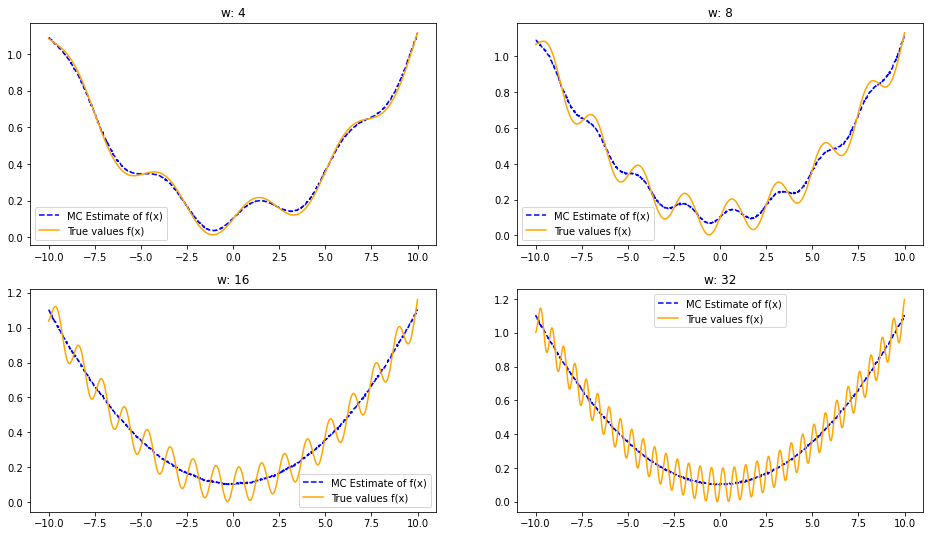

In [6]:
xs = jnp.linspace(range_start, range_end, num_inputs)

mc_f = jnp.zeros((3, num_inputs))
true_f = jnp.zeros((3, num_inputs))

fig = plt.figure(figsize=(16, 9))
ax = fig.subplots(2, 2)

w = 4
for i in range(2):
    for j in range(2):
        mc_f = mc_function(variance, xs, w)
        true_f = foo(xs, w)

        ax[i,j].plot(xs, mc_f, color='blue', label='MC Estimate of f(x)', linestyle='dashed')
        ax[i,j].plot(xs, true_f, color='orange', label='True values f(x)')
        ax[i,j].legend()
        ax[i,j].set_title(f"w: {w}")
        
        w = 2 * w
    
plt.show()

## Reparametrized Gradients

In [7]:
def rp_foo(mean, var, w, eps):
    rp_sample = mean + var * eps
    return foo(rp_sample, w)

def get_rp_gradients(means, variances, xs, w):
    epsilons = jrandom.normal(key=rand_key, shape=(num_inputs, N))
    
    mu_grad = jax.vmap(jax.vmap(grad(rp_foo, 0), in_axes=(0, 0, None, 0)), in_axes=(0, 0, None, 0))
    var_grad = jax.vmap(jax.vmap(grad(rp_foo, 1), in_axes=(0, 0, None, 0)), in_axes=(0, 0, None, 0))
    
    mu_grads = mu_grad(means, variances, w, epsilons)
    var_grads = var_grad(means, variances, w, epsilons)

    return mu_grads, var_grads

## Likelihood ratio gradients

In [36]:
def get_lr_gradients(means, variances, xs, w, baseline=False):
    samples = jrandom.multivariate_normal(
        key=rand_key,
        mean=jnp.array(xs, dtype=jnp.float32),
        cov=jnp.eye(num_inputs, N, dtype=jnp.float32) * variance,
        shape=(N,),
    ).T
    
    log_pdf = jax.scipy.stats.norm.logpdf
    
    mu_grad_logpdf = jax.vmap(jax.vmap(grad(log_pdf, 1), in_axes=(0, 0, 0)), in_axes=(0, 0, 0))
    var_grad_logpdf = jax.vmap(jax.vmap(grad(log_pdf, 2), in_axes=(0, 0, 0)), in_axes=(0, 0, 0))
    
    f = foo(samples, w)
    if baseline:
        f = f - f.mean(axis=1)        
        
    mu_grads = jnp.multiply(mu_grad_logpdf(samples, means, variances), f)
    var_grads = jnp.multiply(var_grad_logpdf(samples, means, variances), f)
    
    return mu_grads, var_grads

## Visualizing the gradient variance

In [84]:
def get_rp_grad_var(means, variances, xs, w):
    rp_mu_grads, rp_var_grads = get_rp_gradients(means, variances, xs, w)
        
    rp_mu_grad_var = jnp.max(jnp.var(rp_mu_grads, axis=1, keepdims=False))
    rp_var_grad_var = jnp.max(jnp.var(rp_var_grads, axis=1, keepdims=False))
    
    return rp_mu_grad_var, rp_var_grad_var

def get_lr_grad_var(means, variances, xs, w, baseline=False):
    lr_mu_grads, lr_var_grads = get_lr_gradients(means, variances, xs, w, baseline)
        
    lr_mu_grad_var = jnp.max(jnp.var(lr_mu_grads, axis=1, keepdims=False))
    lr_var_grad_var = jnp.max(jnp.var(lr_var_grads, axis=1, keepdims=False))
    
    return lr_mu_grad_var, lr_var_grad_var

def get_combined_grad_var(means, variances, xs, w):
    rp_mu_grads,_ = get_rp_gradients(means, variances, xs, w)
    lr_mu_grads,_ = get_lr_gradients(means, variances, xs, w, baseline=True)
    
    rp_mu_var = jnp.var(rp_mu_grads, axis=1, keepdims=False)
    lr_mu_var = jnp.var(lr_mu_grads, axis=1, keepdims=False)

    inv_rp_var = jnp.reciprocal(rp_mu_var)
    inv_lr_var = jnp.reciprocal(lr_mu_var)
    inv_total_var = jnp.reciprocal(jnp.add(inv_rp_var, inv_lr_var))
    rp_ratio = jnp.multiply(inv_total_var, inv_rp_var)
    lr_ratio = 1 - rp_ratio

    weighted_rp_grads = jnp.multiply(rp_ratio, rp_mu_grads)
    weighted_lr_grads = jnp.multiply(lr_ratio, lr_mu_grads)
    combined_grads = jnp.add(weighted_rp_grads, weighted_lr_grads)

    combined_grad_var = jnp.max(jnp.var(combined_grads, axis=1, keepdims=False))
    
    return combined_grad_var

def get_grad_variances(oscillations, xs, means, variances):
    rp_grad_vars = np.zeros((oscillations.shape[0], 2))
    lr_grad_vars = np.zeros((oscillations.shape[0], 2))
    lr_baseline_grad_vars = np.zeros((oscillations.shape[0], 2))
    combined_grad_vars = np.zeros((oscillations.shape[0],))
    for i, w in enumerate(oscillations):
        # RP gradients        
        rp_mu_grad_var, rp_var_grad_var = get_rp_grad_var(means, variances, xs, w)
        
        rp_grad_vars[i, 0] = rp_mu_grad_var
        rp_grad_vars[i, 1] = rp_var_grad_var
        
        # LR gradients            
        lr_mu_grad_var, lr_var_grad_var = get_lr_grad_var(means, variances, xs, w)
        
        lr_grad_vars[i, 0] = lr_mu_grad_var
        lr_grad_vars[i, 1] = lr_var_grad_var
        
        # LR gradients with baseline        
        lr_b_mu_grad_var, lr_b_var_grad_var = get_lr_grad_var(means, variances, xs, w, baseline=True)
        
        lr_baseline_grad_vars[i, 0] = lr_b_mu_grad_var
        lr_baseline_grad_vars[i, 1] = lr_b_var_grad_var
        
        # Naive combination of LR and RP
        combined_grad_var = get_combined_grad_var(means, variances, xs, w)
        combined_grad_vars[i] = combined_grad_var
        
    return rp_grad_vars, lr_grad_vars, lr_baseline_grad_vars, combined_grad_vars


In [85]:
xs = jnp.linspace(range_start, range_end, num_inputs)
oscillations = jnp.linspace(10e-3, 10e3, 100)

means = jnp.stack([jnp.full((N,), x) for x in xs])
variances = jnp.full((num_inputs, N), variance)

rp_grad_vars, lr_grad_vars, lr_baseline_grad_vars, combined_grad_vars = get_grad_variances(
                                                                            oscillations,
                                                                            xs,
                                                                            means,
                                                                            variances
                                                                        )

rp_mu = rp_grad_vars[:, 0]
rp_var = rp_grad_vars[:, 1]

lr_mu = lr_grad_vars[:, 0]
lr_var = lr_grad_vars[:, 1]

lr_baseline_mu = lr_baseline_grad_vars[:, 0]
lr_baseline_var = lr_baseline_grad_vars[:, 1]

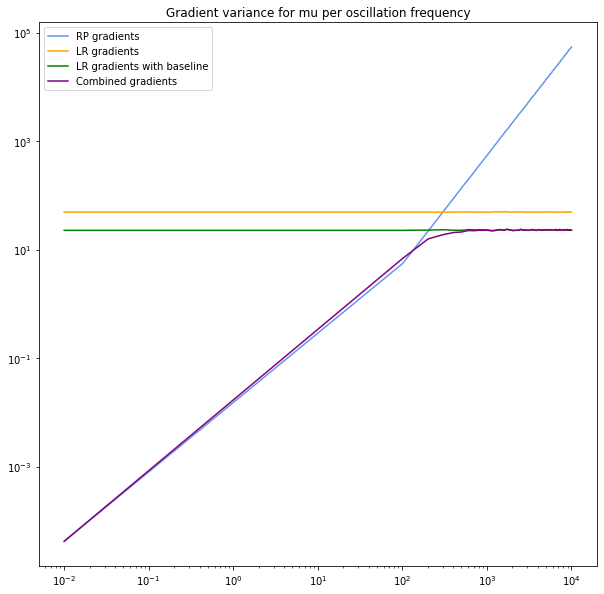

In [86]:
plt.figure(figsize=(10, 10))
plt.plot(oscillations, rp_mu, color="cornflowerblue", label="RP gradients")
plt.plot(oscillations, lr_mu, color="orange", label="LR gradients")
plt.plot(oscillations, lr_baseline_mu, color="green", label="LR gradients with baseline")
plt.plot(oscillations, combined_grad_vars, color="purple", label="Combined gradients")

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title("Gradient variance for mu per oscillation frequency")
plt.show()

## Finite differences gradients

In [28]:
def check_gradients(args):
    # Max rtol that doesn't raise assertion is 6e-3
    return check_grads(rp_foo, args, order=1, atol=None, rtol=6e-3)

def numerical_diff_gradients(means, variances, w, epsilons):
    eps = 1e-4
    batch_foo = jax.vmap(jax.vmap(rp_foo, in_axes=(0, 0, None, 0)), in_axes=(0, 0, None, 0))
    mu_grad_numerical = (batch_foo(means + eps /2., variances, w, epsilons) - \
                        batch_foo(means - eps /2., variances, w, epsilons)) / eps
    var_grad_numerical = (batch_foo(means, variances + eps /2., w, epsilons) - \
                        batch_foo(means, variances - eps /2., w, epsilons)) / eps
    return mu_grad_numerical, var_grad_numerical



In [29]:
means = jnp.stack([jnp.full((N,), x, dtype=jnp.float32) for x in xs])
variances = jnp.full((num_inputs, N), variance, dtype=jnp.float32)
epsilons = jrandom.normal(key=rand_key, shape=(num_inputs, N), dtype=jnp.float32)

mu_grad_manual, var_grad_manual = numerical_diff_gradients(means, variances, w, epsilons)

# print(var_grads[300, :5])
# print(var_grad_manual[300, :5])

check_gradients((means, variances, w, epsilons))